# Treinando uma CNN com o dataset CIFAR100

In [1]:
# Carregando as libs que serão utilizadas
from platform import python_version
import watermark
import warnings
import sys
import os

import tensorflow as tf
import pandas as pd
import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.backend import clear_session

import matplotlib.pyplot as plt    

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# Verificação das versões das libs
%reload_ext watermark
%watermark -a "Versões utilizadas" --iversion

pandas     1.0.5
watermark  2.0.2
numpy      1.18.5
keras      2.4.3
tensorflow 2.2.0
Versões utilizadas


In [3]:
# Dispositivos disponíveis na máquina
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11594003731679826892,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3605448631118340886
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 822149120
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2831340243740060627
 physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:0b:00.0, compute capability: 7.5",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 11493058816
 locality {
   bus_id: 1
   links {
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 2314299376875930054
 physical_device_desc: "device: 1, name: TITAN X (Pascal), pci bus id: 0000:05:00.0, compute capability: 6.1",
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10602760128
 locality {
   bus_id: 1
   links {
  

In [4]:
# Verificando a memória disponível na máquina
!nvidia-smi

Sun Jul 26 08:35:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 24%   45C    P5    12W / 250W |    536MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   42C    P8    10W / 250W |    423MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [5]:
# Carregando o dataset 
train, test = keras.datasets.cifar10.load_data()

In [6]:
# Separando os dados de treino
x_train, y_train = train

In [7]:
# Separando dados para teste e validação
x_aux, y_aux = test

x_test = x_aux[:5000,:]
y_test = y_aux[:5000,:]
x_validation = x_aux[5000:,:]
y_validation = y_aux[5000:,:]

# Remove os dados auxiliares da memória
del x_aux, y_aux

In [8]:
# Convertendo as variáveis target para variáveis categoricas 
y_train_to_categorical = keras.utils.to_categorical(y_train)
y_test_to_categorical = keras.utils.to_categorical(y_test)
y_validation_to_categorical = keras.utils.to_categorical(y_validation)

In [9]:
# Deixa os dados de treinamento na mesma escala
x_train = x_train / 255.
x_test = x_test / 255.
x_validation = x_validation / 255.

In [10]:
# Exibindo o shape dos datasets
print("X train: ", x_train.shape)
print("Y train: ", y_train_to_categorical.shape)
print("X test: ", x_test.shape)
print("Y test: ", y_test_to_categorical.shape)
print("X validation: ", x_validation.shape)
print("Y validation: ", y_validation_to_categorical.shape)

X train:  (50000, 32, 32, 3)
Y train:  (50000, 10)
X test:  (5000, 32, 32, 3)
Y test:  (5000, 10)
X validation:  (5000, 32, 32, 3)
Y validation:  (5000, 10)


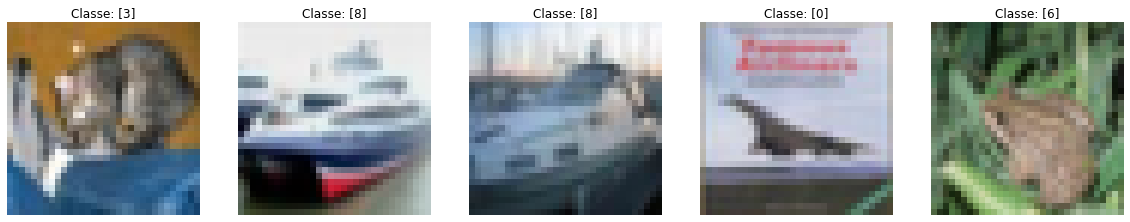

In [11]:
# Exibindo as 5 primeiras imagens do dataset de treino
plt.figure(figsize=(20, 20))
for i in range(1):
    for j in range(5):              
        plt.subplot(2, 5, i * 5 + j + 1)
        plt.imshow(x_test[j])
        plt.title(f"Classe: {y_test[j]}")
        plt.axis('off')
    
plt.show()

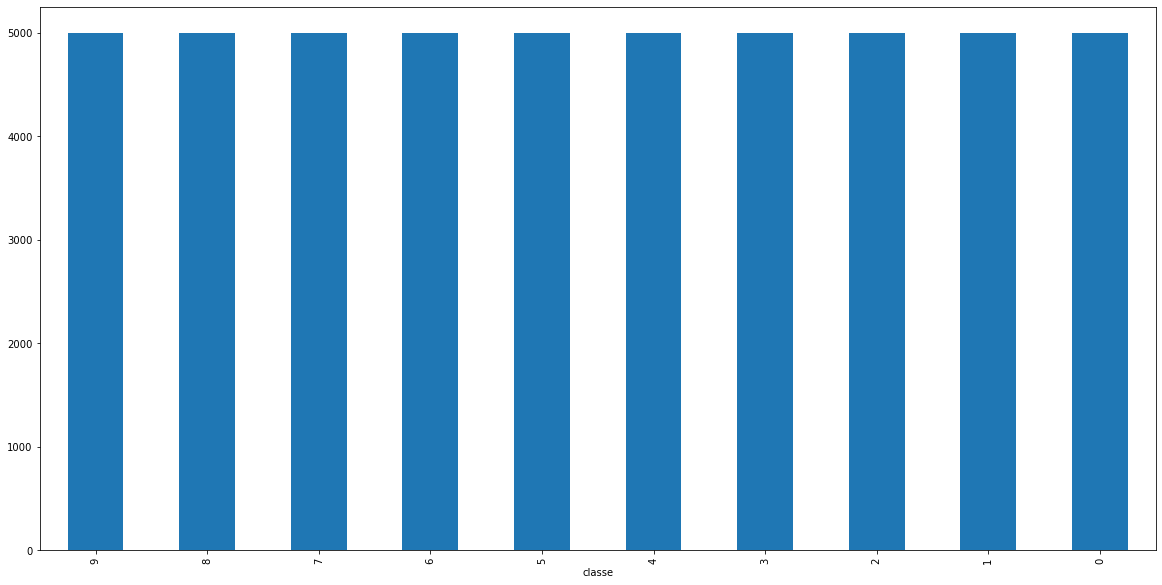

In [12]:
# Verificando a quantidade por classe
df = pd.DataFrame(columns=['classe'])
df['classe'] = y_train.reshape(-1).astype('int32')

plt.figure(figsize=(20, 10))
df.groupby([df['classe']]).size().sort_values(ascending=False).plot(kind='bar')

# Deleta o dataframe para liberar espaço na memória
del df

In [13]:
# Montando o modelo
def cria_modelo():
    model = Sequential()

    # Primeira amada Convolucional
    model.add(Conv2D(input_shape = x_train.shape[1:],
                     filters = 16,
                     kernel_size = (2, 2),
                     kernel_initializer = "normal", 
                     padding = 'same',
                     activation = 'relu'))

    # Primeira camada de Pooling
    model.add(MaxPool2D(pool_size = 2))
    
    # Primeira camada Dropout
    model.add(Dropout(0.25))

    # Segunda camada Convolucional
    model.add(Conv2D(filters = 32, 
                     kernel_size = (2, 2),
                     kernel_initializer = "normal",
                     padding = 'same',
                     activation = 'relu'))       

    # Segunda camada de Pooling
    model.add(MaxPool2D(pool_size = 2))
    
    # Segunda camada Dropout
    model.add(Dropout(0.25))
    
    # Terceira camada Convolucional
    model.add(Conv2D(filters = 64, 
                    kernel_size = (2, 2),
                    padding = "same",
                    kernel_initializer = "normal",
                    activation = "relu"))    
    
    # Terceira camada de Pooling
    model.add(MaxPool2D(pool_size = 2))
    
    # Terceira camada Dropout
    model.add(Dropout(0.25))

    # Camada Flatten
    model.add(Flatten())

    # Primeira camada densa de saída com 256 neurônios e função de ativação relu
    model.add(Dense(256, activation = 'relu'))
    
    # Segunda camada densa de saída com 128 neurônios e função de ativação relu
    model.add(Dense(128, activation = 'relu'))
    
    # Terceira e última camada densa de saída com 100 neurônios e função de ativação softmax
    model.add(Dense(10, activation = 'softmax'))
    
    # Compila o modelo
    model.compile(loss="categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    
    return model

In [14]:
# Para controlar o número dos folds no laço de repetição
num_fold = 1

# Número de folds que serão criados
qtd_fods = 2

# Pasta para salvar os modelos criados
caminho_salvar_modelo = "modelos/"

In [15]:
# Define o EarlyStopping
monitor = EarlyStopping(monitor = "val_loss", min_delta = 1e-1, patience = 5, verbose = 1, mode  ="auto")

# Define a validação cruzada
folds  = KFold(n_splits = qtd_fods, shuffle = True, random_state = 1).split(x_train, y_train)

# Definindo o Data Argumentation
argumentation = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True, 
                                   fill_mode="nearest")

In [ ]:
%time
for train_index, val_index in folds:
    print(f"Treinando o FOLD: {num_fold}")
    
    # Cria os datasets de treinamento a partir da validação cruzada
    x_train_files_fold = x_train[train_index]
    y_train_files_fold = keras.utils.to_categorical(y_train[train_index])  
    
    # Limpa a memória
    clear_session()
    
    # Cria o modelo a partir da função
    model = cria_modelo()
    
    # Define o caminho onde será salvo os modelos
    modelo_fold_salvo = os.path.join(caminho_salvar_modelo, 'pesos_fold_' + str(num_fold) + '.h5')    
    
    # Cria/adiciona as callbacks de checkpoint do modelo, Reduce Learning rate plateau e Early Stopping
    callbacks = [ModelCheckpoint(modelo_fold_salvo,
                                 save_best_only = True,
                                 mode = "max"),
                 ReduceLROnPlateau(monitor = 'loss', 
                                   factor = 0.01, 
                                   patience = 3, 
                                   mode = 'min', 
                                   min_lr = 0.000001,
                                   verbose = 1),
                 monitor] 

    # Treinando o modelo    
    model.fit(
              argumentation.flow(x_train_files_fold, 
                       y_train_files_fold, 
                       batch_size = 64),
                       validation_data = (x_validation, y_validation_to_categorical),
                       callbacks=[callbacks],
                       steps_per_epoch = x_train_files_fold.shape[0] // 64,
                       batch_size = 64,
                       epochs = 100)
    
    # Adiciona 1 ao index
    num_fold += 1

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.7 µs
Treinando o FOLD: 1
Epoch 1/100
390/390 [==============================] - 13s 33ms/step - loss: 2.0200 - accuracy: 0.2452 - val_loss: 1.7678 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 2/100
390/390 [==============================] - 13s 33ms/step - loss: 1.7742 - accuracy: 0.3514 - val_loss: 1.6175 - val_accuracy: 0.4166 - lr: 0.0010
Epoch 3/100
390/390 [==============================] - 13s 33ms/step - loss: 1.6850 - accuracy: 0.3827 - val_loss: 1.6070 - val_accuracy: 0.4246 - lr: 0.0010
Epoch 4/100
390/390 [==============================] - 13s 33ms/step - loss: 1.6250 - accuracy: 0.4042 - val_loss: 1.4809 - val_accuracy: 0.4536 - lr: 0.0010
Epoch 5/100
390/390 [==============================] - 13s 33ms/step - loss: 1.5687 - accuracy: 0.4280 - val_loss: 1.4057 - val_accuracy: 0.4790 - lr: 0.0010
Epoch 6/100
390/390 [==============================] - 13s 33ms/step - loss: 1.5311 - accuracy: 0.4431 - val_loss: 1.3900 - va

In [ ]:
# Cria o modelo final

modelo_final = cria_modelo()

In [ ]:
# Carrega os pesos do último modelo 
caminho_ultimo_model = os.path.join(caminho_salvar_modelo, 'pesos_fold_2.h5' )
modelo_final.load_weights(caminho_ultimo_model)

In [ ]:
# Avalia o modelo
loss, accuracy = modelo_final.evaluate(x_validation, y_validation_to_categorical)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
# Exibindo a arquitetura do modelo
modelo_final.summary()

In [ ]:
# Fazendo previsões com os dados de teste
predict = model.predict(x_test)
predict_to_class = [np.argmax(x) for x in predict]

In [ ]:
# Verificando as 10 primeiras previsões e comparando com as targets
print("Previsto: ", predict_to_class[:10])
print("Esperado: ", [y_test[:10, 0]])

In [ ]:
# Verificando as métricas
sc_ac = accuracy_score(y_test, predict_to_class)
sc_rc = recall_score(y_test, predict_to_class, average='weighted')
sc_pc = precision_score(y_test, predict_to_class, average='weighted')
sc_f1 = f1_score(y_test, predict_to_class, average='weighted')

print("=========== MÉTRICAS =============")
print("Accuracy score: %.2f" % (sc_ac * 100))
print("Recall score: %.2f" % (sc_rc * 100))
print("Precision score: %.2f" % (sc_pc * 100))
print("F1 score: %.2f" % (sc_f1 * 100))

In [ ]:
# Matriz de confusão
print("============ MATRIZ DE CONFUSÃO ================")
print(confusion_matrix(y_test, predict_to_class))